# One Qubit PER
In [Extending quantum probabilistic error cancellation through noise scaling](https://arxiv.org/abs/2108.02237) by Mari et. Al, a method of transforming a QPD representation of gates to produce a noise-scaled gate is set forth. This notebook uses `mitiq` to implement this method for general QPD representations and carries it out on a measurement of $Z$ after the circuit $X\ket{0}$.

In [104]:
#helper libraries
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
from numpy.random import random, permutation

#operator info
from qiskit.quantum_info import Pauli, SuperOp, Kraus, Operator, pauli_basis
from qiskit import QuantumCircuit, Aer, execute 
from qiskit.providers.aer.noise import kraus_error, NoiseModel

#Mitiq
from mitiq.pec.types import OperationRepresentation, NoisyOperation
from mitiq.pec import execute_with_pec

plt.style.use("ggplot")

## Create noise model

Here we use a Pauli noise model because it is easier to simulate than the arbitrary model obtained from Gate Set Tomography, but once the QPD representation is obtained, the rest of the process here can be applied. We choose the overhead $\gamma$ to be the same as the QPD representation obtained from gate set tomography for comparison.

In [132]:
overhead = 1.73 #overhead from GST (noisy Rz version)

#choose random coefficients, enforcing the desired overhead
c1 = np.log(overhead)/2*random()
c2 = (np.log(overhead)/2-c1)*random()
c3 = .5*np.log(overhead)-c1-c2
coeffs = list(permutation([c1, c2, c3]))

In [133]:
n = 1 #number of qubits
F = pauli_basis(1, pauli_list = True) #weight-1 Paulis
T = [Pauli("X"), Pauli("Y"), Pauli("Z")] #labels for coefficients

The following cell leverages the product form of this error model $\Lambda(\cdot) = \prod_{k \in \mathcal{T}}\frac{1}{2}(1+e^{-2\lambda_k})\mathcal{I}(\cdot)+\frac{1}{2}(1-e^{-2\lambda_k})\mathcal{P}_k(\cdot)$ to generate a superoperator representation of the error channel, which will be used later to construct the noisy simulator and specify the noisy pauli gates that can be applied.

In [134]:
channel = SuperOp(np.identity(4)) #Start with identity map

#compute above product
for i,lmbdak in enumerate(coeffs):
    op = .5*SuperOp(T[i])*(1-np.exp(-2*lmbdak))+.5*(1+np.exp(-2*lmbdak))*np.identity(4);
    channel = channel.compose(op);

noise_model = NoiseModel() #create noise model from error channel
noise_model.add_all_qubit_quantum_error(channel, ['id', 'x','y','z']) #add noise to all gates
basis_gates = noise_model.basis_gates

The inverse of this channel can be computed by taking the Walsh-hadamard transformation of the inverses of the fidelities:

In [136]:
def s_prod(j, k): #symplectic inner product
    return {True:0,False:1}[F[j].compose(F[k]) == F[k].compose(F[j])]

M = [[s_prod(j,k) for k in range(len(F))] for j in range(len(F))] #Use a matrix to express as system of linear equations

f = np.exp(np.multiply(-2.0, np.dot(M,[0]+coeffs))) #find ideal fidelities
        
def WHtransform(k): #Walsh-Hadamard transform with inverse fidelities
    return 1/4**n*np.sum([(-1)**s_prod(k,j)*1/f[j] for j in range(len(F))])
    
pauli_coeffs = [WHtransform(k) for k in range(len(F))] #get coefficients

Now we have a representation of the inverse of the noise channel written as a QPD of Pauli operators. We can multiply this inverse by the gate we want to mitigate to get the QPD representation of the gate we want to mitigate

In [147]:
gate_to_mitigate = Pauli('X') #the gate to be turned into a QPD
noisy_ops = [SuperOp(P).compose(channel) for P in F] #Noisy operator base are all paulis with added noise

rep_dict = {}
for (coeff,P,noisy_op) in zip(pauli_coeffs,F,noisy_ops):
    qc = QuantumCircuit(1) #ideal quantum circuit representing noisy op
    P = Pauli(gate_to_mitigate.compose(P).to_label()[-1]) #hack to get rid of global phase, breaks without this
    qc.append(P.to_instruction(),[0]) #insert the pauli into the ideal circuit
    rep_dict[NoisyOperation(qc, noisy_op.data)] = coeff

ideal = QuantumCircuit(1)
ideal.append(gate_to_mitigate,[0])
op_rep = OperationRepresentation(ideal, rep_dict)
print(op_rep) #print the operator representation

q_0: ───X─── = 1.356*(q_0: ───X───)-0.327*(q_0: ───I───)-0.006*(q_0: ───Z───)-0.023*(q_0: ───Y───)


The canonical noise scaling is carried out by a method with takes an `OperationRepresentation` and returns a noise-scaled version. The PEC distribution in `op_rep` can be broken into negative and positive volumes, which are both TPCP channels, multiplied by corresponding negative and positive overheads:
$$
\lambda^+ \Phi^+-\lambda^-\Phi^-
$$
To convert this to the noise-scaled representation, all of the negative coefficients are scaled by $(1-\xi)$ and the positive coefficients are scaled by $\frac{\gamma^+-\xi\gamma^-}{\gamma^+}$, resulting in the noise-scaled distribution
$$
(\gamma^+-\lambda \gamma^-)\Phi^+-(1-\lambda)\gamma^- \Phi^-
$$

In [148]:
#convert PEC rep to PER rep
def get_canonical_noise_scaled_rep(op_rep : OperationRepresentation,
                                   lmbda) -> OperationRepresentation:
    #copy data from previous rep
    noisy_ops = op_rep.noisy_operations
    coeffs = list(op_rep.coeffs)
    ideal_program = op_rep.ideal

    #define terms
    gammaminus = .5*(op_rep.norm-1)
    gammaplus = .5*(op_rep.norm+1)

    #scale coefficients accordingly
    for (i,coeff) in enumerate(coeffs):
        if coeff < 0:
            coeffs[i] = coeff*(1-lmbda)
        else:
            coeffs[i] = coeff/gammaplus*(gammaplus-lmbda*gammaminus)
    
    #construct and return new representation
    scaled_rep_dict = dict(zip(noisy_ops, coeffs))
    return OperationRepresentation(ideal_program, scaled_rep_dict)

Get the unmitigated expectation value of the ideal circuit

In [149]:
test_shots = 10000
backend = Aer.get_backend('qasm_simulator')
circ = ideal.copy()
circ.measure_all()
counts = execute(circ, backend, noise_model = noise_model, basis_gates = basis_gates, shots=test_shots).result().get_counts()
unmitigated_value = (counts.get('0', 0)-counts.get('1',0))/test_shots
print(unmitigated_value)


-0.602


Define a function to act as the `Executor` passed to the `execute_with_pec`. This function is a substitute for a routine to find the expectation value of a circuit on a noisy quantum backend.

In [141]:
shots = 200
def noisy_executor(circ):
    qc = circ.copy()
    qc.measure_all()
    counts = execute(qc, backend, noise_model = noise_model, basis_gates = basis_gates, optimization_level = 0, shots=shots).result().get_counts()
    return (counts.get('0', 0)-counts.get('1',0))/shots

Test if PEC is working before running full scan, value should be close to $-1$ within two digits of precision.

## Find estimator for different values of $\lambda$

In [143]:
lmbdas = [0, .5, 1, 1.5, 2]
mitigated_values = []
samples = 250
#Run the procedure for each lambda
mitigated_values = []
pec_errors = []
for lmbda in lmbdas:
    result, metadata = execute_with_pec(ideal, noisy_executor, representations=[get_canonical_noise_scaled_rep(op_rep, lmbda)], num_samples = samples, full_output=True)
    err = metadata["pec_error"]
    pec_errors.append(err)
    mitigated_values.append(result)

In [144]:
from scipy.optimize import curve_fit
linear = lambda x,a,b: a*x+b
popt, pcov = curve_fit(linear, lmbdas, mitigated_values)

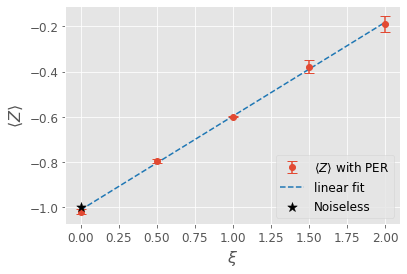

In [151]:
plt.figure(figsize=(6,4))
xrange = np.linspace(0, max(lmbdas), 100)
mv = plt.errorbar(lmbdas, mitigated_values,pec_errors, capsize=5, capthick=1, linestyle = "None", marker = "o")
lfit, = plt.plot(np.linspace(0,max(lmbdas), 30), [linear(x, *popt) for x in np.linspace(0, max(lmbdas), 30)], linestyle="--", color="tab:blue")
plt.xlabel(r"$\xi$", fontsize = 16)
plt.ylabel(r"$\langle Z \rangle$", fontsize = 16)
plt.tick_params(axis= "both", labelsize = 12)
exact = plt.scatter(0, -1, marker = "*", color = "black", zorder = 10, s=100)
plt.legend([mv, lfit, exact], [r'$\langle Z \rangle$ with PER','linear fit', "Noiseless"], loc="lower right", fontsize = 12)

In [150]:
popt[1]

-1.0112246381549075